In [1]:
# Operações de Crédito - Conta 16000001 (filtragem maiores saldos)

import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')

query = """
WITH RankedData AS (
    SELECT
        *,
        ROW_NUMBER() OVER(PARTITION BY data ORDER BY "SALDO" DESC) AS rn
    FROM
        balancetes_bancos
    WHERE
        "CONTA" = '16000001'
)
SELECT
    *
FROM
    RankedData
WHERE
    SALDO > 1000000
--    rn <= 10;
"""

model = pd.read_sql_query(query, conn)

conn.close()

model = model[['data', 'cnpj', 'NOME_INSTITUICAO', 'SALDO']]
model['cnpj'] = model['cnpj'].astype(int)
model = model.rename(columns={'SALDO': 'operacoes_de_credito'})


In [2]:
# Passivo Total -  Conta 99999995

import numpy as np

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '99999995'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'passivo_total'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [3]:
# Patrimônio Líquido - Conta 60000002

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '60000002'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'patrimonio_liquido'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [4]:
# Alavancagem (lever)

model['lever'] = 100 * model['passivo_total'] / model['patrimonio_liquido']

In [5]:
# Fundos Remunerados
'''
Depósitos de Poupança (4.1.2.00.00-3)
Depósitos Interfinanceiros (4.1.3.00.00-6)
Depósitos a Prazo (4.1.5.00.00-2)
Depósitos sob Aviso (4.1.4.00.00-9)
Obrigações por Operações Compromissadas (4.2.0.00.00-6)
Obrigações por Títulos e Valores Mobiliários (4.3.0.00.00-5)
Obrigações por Empréstimos e Repasses (4.6.0.00.00-2)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('41200003', '41300006', '41500002', '41400009', '42000006', '43000005', '46000002')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'fundos_remunerados'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [6]:
# Ativos rentáveis
'''
Aplicações Interfinanceiras de Liquidez (1.2.0.00.00-5)
Títulos e Valores Mobiliários e Instrumentos Financeiros Derivativos (1.3.0.00.00-4)
Operações de Crédito (1.6.0.00.00-1)
Operações de Arrendamento Mercantil (1.7.0.00.00-0)
Outros Créditos (1.8.0.00.00-9)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('12000005', '13000004', '16000001', '17000000', '18000009')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'ativos_rentaveis'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [7]:
# ibf (Interest Bearing Funds / Total Earning Assets)

model['ibf'] = 100 * model['fundos_remunerados'] / model['ativos_rentaveis']

In [8]:
# Depósitos à Vista (Depósitos Não Remunerados) - Conta 41100000
'''
Depósitos à Vista (4.1.1.00.00-0)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '41100000'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'depositos_a_vista'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)



In [9]:
# Depósitos - Conta 41000007

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '41000007'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'depositos'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [10]:
# Non-Interest Bearing Deposits (nibd) = Depósitos à vista (Não Remunerados) / Depósitos Totais

model['nibd'] = 100 * model['depositos_a_vista'] / model['depositos']

In [11]:
# Custos Operacionais
'''
Despesas de Captação (8.1.1.00.00-8)
Despesas de Obrigações por Empréstimos e Repasses (8.1.2.00.00-1)
Despesas de Arrendamento Mercantil (8.1.3.00.00-4)
Despesas de Câmbio (8.1.4.00.00-7)
Despesas com Títulos e Valores Mobiliários e Instrumentos Financeiros Derivativos (8.1.5.00.00-0)
Despesas Administrativas (8.1.7.00.00-6)
Despesas de Provisões Operacionais (8.1.8.30.00-0)
Outras Despesas Operacionais (8.1.9.99.00-6)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('81100008', '81200001', '81300004', '81400007', '81500000', '81700006', '81830000', '81999006')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'custos_operacionais'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [12]:
# Ativo Total - Conta 39999993

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '39999993'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'ativo_total'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [13]:
# Custos Operacionais sobre o Ativo (opc)

model['opc'] = -100 * model['custos_operacionais'] / model['ativo_total']

In [14]:
# Ativos de Alta Liquidez (Caixa e Equivalentes de Caixa)
'''
Caixa (1.1.1.00.00-9)
Depósitos Bancários (1.1.2.00.00-2)
Reservas Livres (1.1.3.00.00-5)
Aplicações em Operações Compromissadas (1.2.1.00.00-8)
Aplicações em Depósitos Interfinanceiros (1.2.2.00.00-1)
Disponibilidades em Moedas Estrangeiras (1.1.5.00.00-1)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('11100009', '11200002', '11300005', '12100008', '12200001', '11500001')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'ativo_liquido'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [15]:
# Passivos de Curto Prazo (Obrigações Exigíveis no Circulante)
'''
Depósitos à Vista (4.1.1.00.00-0)
Obrigações por Operações Compromissadas (4.2.0.00.00-6)
Depósitos Interfinanceiros (4.1.3.00.00-6)
'''

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('41100000', '42000006', '41300006')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'passivo_curto_prazo'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)

In [16]:
# Liquidez (liquid)

model['liquid'] = 100 * model['ativo_liquido'] / model['passivo_curto_prazo']

In [17]:
# Renda de Serviços - Conta 71700009

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '71700009'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'renda_servicos'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)

In [18]:
# Receita Operacional - Conta 71000008

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '71000008'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'receita_operacional'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)

In [19]:
# razão entre receitas de serviços e o total de receitas operacionais (servr)

model['servr'] = 100 * model['renda_servicos'] / model['receita_operacional']

In [56]:
# Market Share (mktsh)

model['credito_total'] = model['operacoes_de_credito'].groupby(model['data']).transform('sum')
model['mktsh'] = 100 * (model['operacoes_de_credito'] / model['credito_total'])

model['mktsh_big'] = model['mktsh'].apply(lambda x: 1 if x > 1 else 0)
model['mktsh_medium'] = model['mktsh'].apply(lambda x: 1 if x < 1 and x > 0.05 else 0)
model['mktsh_small'] = model['mktsh'].apply(lambda x: 1 if x <= 0.05 else 0)


In [21]:
# Ativos liquidos não remunerados
'''
Caixa (1.1.1.00.00-9)
Reservas Livres (1.1.3.00.00-3)
Depósitos Bancários (1.1.2.00.00-6)
'''
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('11100009', '11900003', '11200006')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'ativos_liquidos_nao_remunerados'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)
'''

'\nconn = sqlite3.connect(\'dados/banking.db\')\nquery = """\nSELECT\n    data,\n    cnpj,\n    SUM("SALDO") AS saldo_total_agregado\nFROM\n    balancetes\nWHERE\n    "CONTA" IN (\'11100009\', \'11900003\', \'11200006\')\nGROUP BY\n    data,\n    cnpj\nORDER BY\n    data,\n    cnpj;\n"""\n\ntable = pd.read_sql_query(query, conn)\nconn.close()\n\ntable[\'cnpj\'] = table[\'cnpj\'].astype(int)\ntable = table.rename(columns={\'saldo_total_agregado\': \'ativos_liquidos_nao_remunerados\'})\n\nmodel = pd.merge(\n    model,\n    table,\n    on=[\'data\', \'cnpj\'],\n    how=\'left\'\n)\n'

In [22]:
# Receitas de Juros e Similares (Rendas)
'''
Rendas De Operacoes De Credito (7.1.1.00.00-1)
Rendas de Arrendamento Mercantil (7.1.2.00.00-4)
Rendas de Aplicações Interfinanceiras de Liquidez (7.1.4.00.00-0)
Rendas de Títulos e Valores Mobiliários (7.1.5.00.00-3)
Rendas de Outras Operações Com Características de Crédito (7.1.6.00.00-8)
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('71100001', '71200004', '71400000', '71500003', '71600008')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'receita_juros'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [23]:
# Despesas de Juros e Encargos (Custos de Captação)
'''
Despesas de captação (81100008)
Despesas de Obrigações por Empréstimos e Repasses (8.1.2.00.00-1)
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('81100008', '81200001')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'despesa_captacao'})
table['despesa_captacao'] = table['despesa_captacao'] * (-1)

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [24]:
# Ativos Remunerados Médios (Média do Balanço)
'''
Operações de Crédito (1.6.0.00.00-1)
Títulos e Valores Mobiliários (1.3.0.00.00-4)
Arrendamento Mercantil (1.7.0.00.00-1)
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('16000001', '13000004', '17000001')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'ativos_remunerados'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [25]:
# Receita e despesa de juros (%)

model['taxa_receita_juros'] = model['receita_juros'] / model['ativos_remunerados']
model['taxa_despesa_captacao'] = model['despesa_captacao'] / model['ativos_remunerados']

In [26]:
# spread = taxa_emprestimos - taxa_captacao

model['spread'] = 100 * (model['receita_juros'] - model['despesa_captacao']) / model['ativos_remunerados']

In [60]:
# Criando tabela variables

variables = model[['data', 'cnpj', 'NOME_INSTITUICAO', 'spread', 'nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'mktsh', 'mktsh_big', 'mktsh_medium', 'mktsh_small']]
# Variáveis lags
'''
coluna_grupo = 'cnpj'
colunas_para_verificar = ['nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'mktsh']

for col in colunas_para_verificar:
    variables[f'{col}_lag_2'] = (variables.groupby(coluna_grupo)[col].shift(2))
    variables[f'{col}_lag_1'] = (variables.groupby(coluna_grupo)[col].shift(1))
    variables[f'{col}_lag_3'] = (variables.groupby(coluna_grupo)[col].shift(3))
'''
# Dummies de tempo
dummies_tempo = pd.get_dummies(variables['data'], drop_first=True)
dummies_tempo = dummies_tempo.astype(int)
variables = pd.concat([variables, dummies_tempo], axis=1)

# Removendo linhas com valores nulos, exceto na coluna NOME_INSTITUICAO
todas_colunas = variables.columns.tolist()
colunas_para_verificar = [col for col in todas_colunas if col != 'NOME_INSTITUICAO']
variables = variables.dropna(how='any', subset=colunas_para_verificar)


In [28]:
# Tratando outliers

print(variables['mktsh'].quantile(0.25))
print(variables['mktsh'].quantile(0.75))
print(variables['mktsh'].mean())
print(variables['mktsh'].median())
print(variables['mktsh'].std())


0.013383081325395852
0.24167404712075496
0.8587728337546983
0.04937358434084383
3.3189745615071478


In [61]:
colunas_para_analisar = ['spread', 'nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr']

# True significa que a linha *será removida* (outlier).
# Começamos com False, assumindo que nenhuma linha será removida inicialmente.
mascara_outliers_acumulada = pd.Series(False, index=variables.index)

print(f"Tamanho do DataFrame antes da remoção: {len(variables)}")

for col in colunas_para_analisar:
    Q1 = variables[col].quantile(0.10)
    Q3 = variables[col].quantile(0.90)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    mascara_outliers_coluna = (variables[col] < limite_inferior) | (variables[col] > limite_superior)

    mascara_outliers_acumulada = mascara_outliers_acumulada | mascara_outliers_coluna

    num_outliers_col = mascara_outliers_coluna.sum()
    print(f"Coluna '{col}': {num_outliers_col} outliers identificados (Limites: [{limite_inferior:.2f}, {limite_superior:.2f}])")


# Criamos uma máscara de linhas *a serem mantidas* (True = não é outlier)
mascara_a_manter = ~mascara_outliers_acumulada # O til (~) inverte a máscara
variables_limpo = variables[mascara_a_manter]

print(f"\nTotal de linhas removidas: {mascara_outliers_acumulada.sum()}")
print(f"Tamanho do DataFrame após a remoção: {len(variables_limpo)}")

Tamanho do DataFrame antes da remoção: 17325
Coluna 'spread': 643 outliers identificados (Limites: [-67.28, 114.29])
Coluna 'nibd': 605 outliers identificados (Limites: [-35.05, 58.83])
Coluna 'ibf': 15 outliers identificados (Limites: [-62.05, 187.49])
Coluna 'lever': 401 outliers identificados (Limites: [-13848.77, 26223.39])
Coluna 'opc': 357 outliers identificados (Limites: [-7.31, 13.06])
Coluna 'liquid': 793 outliers identificados (Limites: [-3197.09, 5369.37])
Coluna 'servr': 167 outliers identificados (Limites: [-21.74, 36.49])

Total de linhas removidas: 2419
Tamanho do DataFrame após a remoção: 14906


In [62]:
# Modelo - Primeiro Estágio
import statsmodels.api as sm

#colunas_X_originais = ['nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'nibd_lag_1', 'nibd_lag_2', 'nibd_lag_3', 'ibf_lag_1', 'ibf_lag_2', 'ibf_lag_3', 'lever_lag_1', 'lever_lag_2', 'lever_lag_3', 'opc_lag_1', 'opc_lag_2', 'opc_lag_3', 'liquid_lag_1', 'liquid_lag_2', 'liquid_lag_3', 'servr_lag_1', 'servr_lag_2', 'servr_lag_3']
colunas_X_originais = ['nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'mktsh', 'mktsh_big', 'mktsh_medium', 'mktsh_small']
colunas_X = colunas_X_originais + list(dummies_tempo.columns)
X = variables_limpo[colunas_X]
y = variables_limpo['spread']

stage1 = sm.OLS(y, sm.add_constant(X)).fit()
results_stage1 = stage1
print(results_stage1.summary())

spread_estimado = variables_limpo[['data', 'cnpj', 'NOME_INSTITUICAO']]
spread_estimado['spread_estimado'] = results_stage1.predict()
spread_estimado['spread_puro'] = results_stage1.params['const'] + variables_limpo[dummies_tempo.columns].dot(results_stage1.params[dummies_tempo.columns])


                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     107.8
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:50   Log-Likelihood:                -58096.
No. Observations:               14906   AIC:                         1.166e+05
Df Residuals:                   14717   BIC:                         1.180e+05
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.9209      1.031     12.537   

/tmp/ipykernel_1154207/1648603354.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_estimado['spread_estimado'] = results_stage1.predict()
/tmp/ipykernel_1154207/1648603354.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_estimado['spread_puro'] = results_stage1.params['const'] + variables_limpo[dummies_tempo.columns].dot(results_stage1.params[dummies_tempo.columns])


<Figure size 1500x600 with 0 Axes>

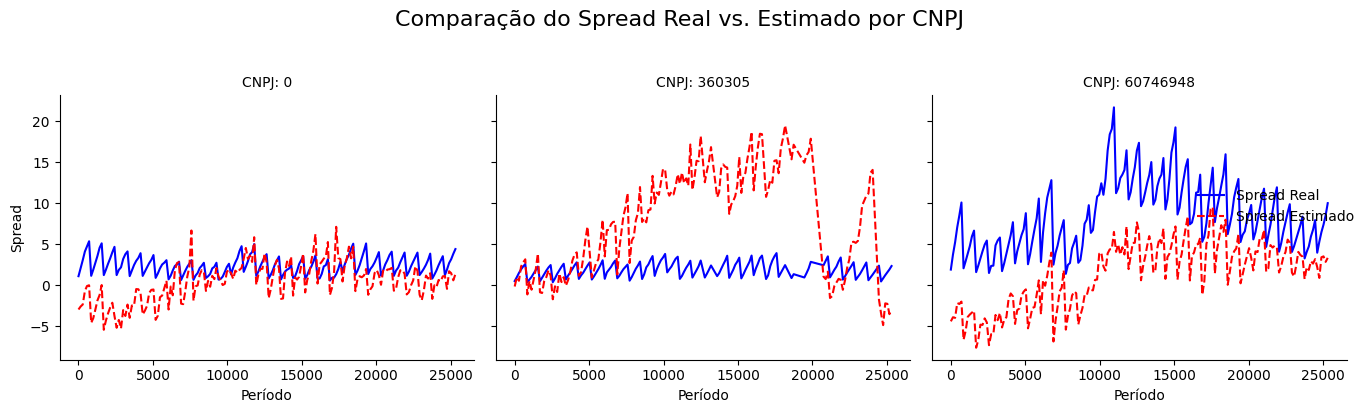

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns


df_plot = pd.DataFrame({
    'spread_real': results_stage1.model.endog,
    'spread_estimado': results_stage1.predict(),
    'cnpj': variables_limpo['cnpj'],
    'data': variables_limpo.index  # Assumindo que a coluna de tempo está no índice (ou use variables_limpo['data'])
})


cnpjs_selecionados = df_plot['cnpj'].unique()[:3]
df_selecionado = df_plot[df_plot['cnpj'].isin(cnpjs_selecionados)]

# ----------------------------------------------------
# 3. Plotar Gráfico de Série Temporal por Grupo
# ----------------------------------------------------

plt.figure(figsize=(15, 6))

# Usar Seaborn para criar múltiplos gráficos (subplots) um para cada CNPJ
# 'col=cnpj' cria uma coluna de gráficos para cada CNPJ
g = sns.FacetGrid(df_selecionado, col='cnpj', col_wrap=3, height=4, sharey=True)

# Plotar o valor REAL
g.map(sns.lineplot, 'data', 'spread_real', label='Spread Real', color='blue', linewidth=1.5)

# Plotar o valor ESTIMADO (a linha de regressão)
g.map(sns.lineplot, 'data', 'spread_estimado', label='Spread Estimado', color='red', linestyle='--', linewidth=1.5)

# Configurações gerais
g.set_axis_labels("Período", "Spread")
g.set_titles(col_template="CNPJ: {col_name}")
g.add_legend()
plt.suptitle('Comparação do Spread Real vs. Estimado por CNPJ', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

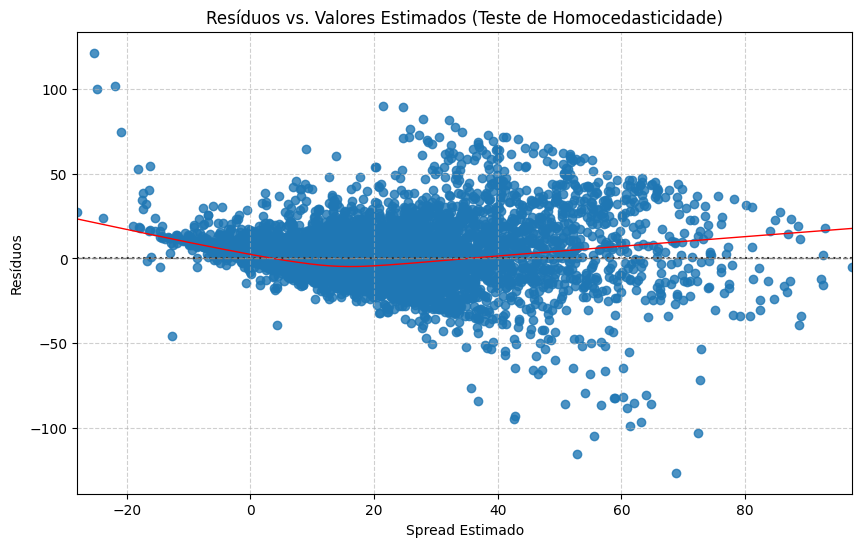

In [64]:
# Gráfico dos resíduos vs. valores estimados
plt.figure(figsize=(10, 6))
sns.residplot(
    x=results_stage1.fittedvalues, # Valores estimados
    y=results_stage1.resid,        # Resíduos
    lowess=True,                   # Adiciona uma linha de ajuste local (para ver tendências)
    line_kws={'color': 'red', 'lw': 1}
)
plt.title('Resíduos vs. Valores Estimados (Teste de Homocedasticidade)')
plt.xlabel('Spread Estimado')
plt.ylabel('Resíduos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.show()

<Figure size 600x600 with 0 Axes>

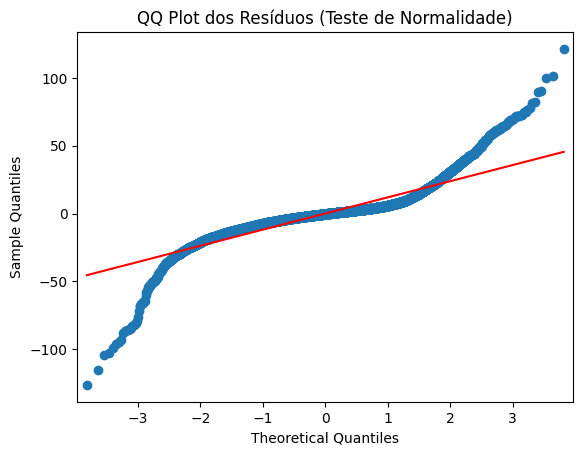

In [65]:
# QQ Plot (Normalidade dos resíduos)

plt.figure(figsize=(6, 6))
sm.qqplot(results_stage1.resid, line='s') # line='s' desenha a linha para distribuição normal padronizada
plt.title('QQ Plot dos Resíduos (Teste de Normalidade)')
plt.show()

In [34]:
# Teste de Wald para restrições lineares
'''
restricoes_wald = ['nibd_lag_1', 'nibd_lag_2', 'nibd_lag_3', 'ibf_lag_1', 'ibf_lag_2', 'ibf_lag_3', 'lever_lag_1', 'lever_lag_2', 'lever_lag_3', 'opc_lag_1', 'opc_lag_2', 'opc_lag_3', 'liquid_lag_1', 'liquid_lag_2', 'liquid_lag_3', 'servr_lag_1', 'servr_lag_2', 'servr_lag_3']

teste_wald = results_stage1.wald_test(restricoes_wald)
print(teste_wald)

estatistica_wald = teste_wald.statistic[0][0]
p_valor_wald = teste_wald.pvalue

print(f"\nEstatística do Teste de Wald: {estatistica_wald:.4f}")
print(f"Valor p: {p_valor_wald:.4f}")
'''

'\nrestricoes_wald = [\'nibd_lag_1\', \'nibd_lag_2\', \'nibd_lag_3\', \'ibf_lag_1\', \'ibf_lag_2\', \'ibf_lag_3\', \'lever_lag_1\', \'lever_lag_2\', \'lever_lag_3\', \'opc_lag_1\', \'opc_lag_2\', \'opc_lag_3\', \'liquid_lag_1\', \'liquid_lag_2\', \'liquid_lag_3\', \'servr_lag_1\', \'servr_lag_2\', \'servr_lag_3\']\n\nteste_wald = results_stage1.wald_test(restricoes_wald)\nprint(teste_wald)\n\nestatistica_wald = teste_wald.statistic[0][0]\np_valor_wald = teste_wald.pvalue\n\nprint(f"\nEstatística do Teste de Wald: {estatistica_wald:.4f}")\nprint(f"Valor p: {p_valor_wald:.4f}")\n'

In [66]:
# Segundo Estágio - CDI

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    cdi_estimado
"""

cdi = pd.read_sql_query(query, conn)

conn.close()

In [ ]:
spread_puro = spread_estimado[['data', 'spread_puro']].drop_duplicates()
spread_puro['spread_puro'] = spread_puro['spread_puro']
spread_puro['cdi'] = spread_puro['data'].map(cdi.set_index('data')['cdi'])

spread_puro = pd.merge(
    spread_puro,
    cdi[['data', 'cond_vol']],
    on=['data'],
    how='left'
)

#spread_puro = spread_puro.dropna(how='any', subset='cond_vol')


In [ ]:
# PIM-PF
import ipeadatapy as ipea

pim = ipea.timeseries('PIMPFN12_QIIGSNNAS12')
pim['data'] = pim.index
pim['data'] = pd.to_datetime(pim['data'], format='%Y-%m').dt.strftime('%Y-%m')
pim = pim.rename(columns={'VALUE (-)': 'pim'})
#pim['pim'] = pim['pim'] * 100
pim['pim-pf'] = pim['pim'].pct_change() * 100

spread_puro = pd.merge(
    spread_puro,
    pim[['data', 'pim-pf']],
    on=['data'],
    how='left'
)


In [ ]:
# Inflação (IPCA)

inflacao = ipea.timeseries('PAN12_IPCAG12')
inflacao['data'] = inflacao.index
inflacao['data'] = pd.to_datetime(inflacao['data'], format='%Y-%m').dt.strftime('%Y-%m')
inflacao = inflacao.rename(columns={'VALUE ((% a.a.))': 'ipca'})
inflacao['ipca'] = inflacao['ipca'] * 100

spread_puro = pd.merge(
    spread_puro,
    inflacao[['data', 'ipca']],
    on=['data'],
    how='left'
)

spread_puro = spread_puro.dropna(how='any', subset=['cond_vol'])


In [ ]:
X = spread_puro[['cdi', 'cond_vol', 'ipca', 'pim-pf']]
y = spread_puro['spread_puro']

reg = sm.OLS(y, sm.add_constant(X)).fit()
results_reg = reg
print(results_reg.summary())


                            OLS Regression Results                            
Dep. Variable:            spread_puro   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     25.18
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.00e-16
Time:                        16:53:54   Log-Likelihood:                -359.78
No. Observations:                 177   AIC:                             729.6
Df Residuals:                     172   BIC:                             745.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8947      0.517     34.608      0.0

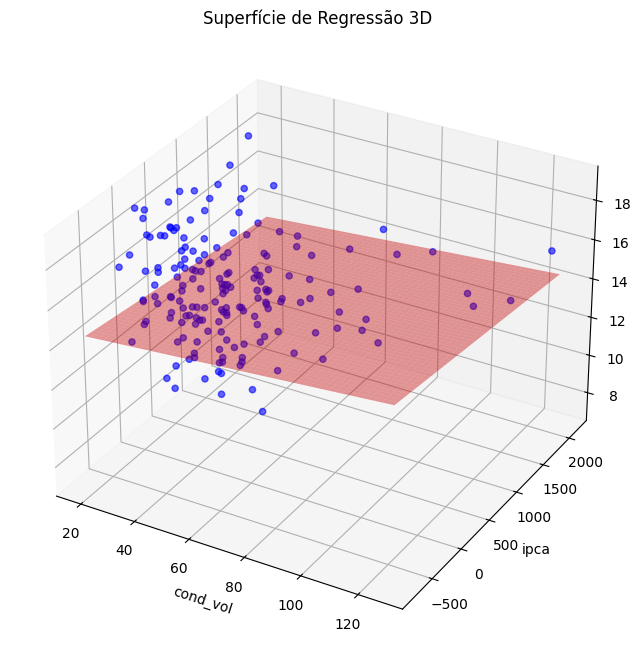

In [70]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Definir os limites do plot
x1_range = np.linspace(X['cond_vol'].min(), X['cond_vol'].max(), 50)
x2_range = np.linspace(X['ipca'].min(), X['ipca'].max(), 50)
X1, X2 = np.meshgrid(x1_range, x2_range)

# 2. Calcular a superfície estimada
# y_hat = beta0 + beta1*X1 + beta2*X2
Z = results_reg.params['const'] + results_reg.params['cond_vol'] * X1 + results_reg.params['ipca'] * X2

# 3. Plotar
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos de dados reais
ax.scatter(X['cond_vol'], X['ipca'], y, c='blue', marker='o', alpha=0.6, label='Spread Puro Real')

# Plotar a superfície de regressão
ax.plot_surface(X1, X2, Z, alpha=0.4, color='red', label='Superfície Estimada')

ax.set_xlabel('cond_vol')
ax.set_ylabel('ipca')
ax.set_zlabel('spread_puro')
ax.set_title('Superfície de Regressão 3D')
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1154207/2160536761.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('Spread Puro Estimado ($\hat{y}$)')


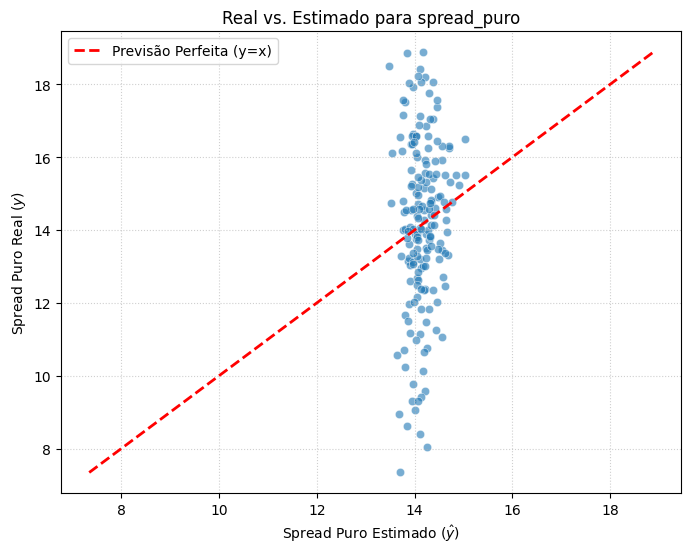

In [71]:
# Gráfico de Dispersão: Valores Reais vs. Estimados

# 1. Obter os valores reais (y) e estimados (y_hat)
y_real = results_reg.model.endog
y_estimado = results_reg.predict()

plt.figure(figsize=(8, 6))

# 2. Plotar os valores reais vs. estimados
sns.scatterplot(x=y_estimado, y=y_real, alpha=0.6)

# 3. Adicionar a Linha de 45 Graus (onde y_real = y_estimado)
# Esta linha representa a previsão perfeita do modelo
min_val = min(y_real.min(), y_estimado.min())
max_val = max(y_real.max(), y_estimado.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Previsão Perfeita (y=x)')

plt.title('Real vs. Estimado para spread_puro')
plt.xlabel('Spread Puro Estimado ($\hat{y}$)')
plt.ylabel('Spread Puro Real ($y$)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()